In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering


In [4]:
data = pd.read_csv('./processed_data1.csv')
frac_data = data.sample(frac = 0.01) 


In [5]:
normalized_data = (data - data.mean())/data.std()
normalized_frac_data = (frac_data - frac_data.mean())/frac_data.std()

correlation_matrix = normalized_frac_data.corr()

print(correlation_matrix)

day   weekday      hour  event_type  product_id  \
day           1.000000  0.029604 -0.025582    0.010445    0.053475   
weekday       0.029604  1.000000  0.022563    0.014698    0.009148   
hour         -0.025582  0.022563  1.000000   -0.001600    0.007925   
event_type    0.010445  0.014698 -0.001600    1.000000    0.021875   
product_id    0.053475  0.009148  0.007925    0.021875    1.000000   
category_id  -0.002410 -0.000689  0.002067   -0.028769    0.233689   
brand         0.020063 -0.005397 -0.004399   -0.063544    0.263960   
price        -0.013447 -0.012465 -0.004108   -0.157675   -0.075091   
user_id       0.660260  0.001462 -0.002422   -0.079406    0.011874   
user_session  0.977772  0.039322  0.009925    0.005779    0.049026   

              category_id     brand     price   user_id  user_session  
day             -0.002410  0.020063 -0.013447  0.660260      0.977772  
weekday         -0.000689 -0.005397 -0.012465  0.001462      0.039322  
hour             0.002067 -0.004

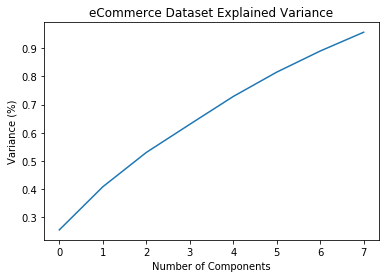

In [21]:
pca = PCA(random_state=1, n_components=8)
pca.fit(normalized_frac_data.values)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('eCommerce Dataset Explained Variance')
plt.show()

In [27]:
normalized_frac_data = pd.DataFrame(pca.transform(normalized_frac_data))

ValueError: operands could not be broadcast together with shapes (2650,8) (10,) 

In [29]:
print(pca.components_)

[[-1.97325816e-17 -0.00000000e+00 -9.08177850e-20  4.96929205e-13
   1.00000000e+00  1.17238004e-17  1.65937103e-18  2.78764882e-13
   2.56775935e-14]
 [ 1.07774062e-07  9.12159027e-10  8.74393558e-10  2.87824645e-04
   2.78626281e-13 -3.59639172e-09 -7.73766899e-09 -9.99999944e-01
  -1.73006411e-04]
 [-1.99216045e-06 -1.07945565e-08 -1.06711905e-08 -9.99998549e-01
   4.97051752e-13 -1.59038863e-06  3.78837987e-07 -2.87533761e-04
  -1.67902885e-03]
 [ 7.53887425e-06  5.79909421e-07  3.23429772e-08 -1.67897902e-03
  -2.47948604e-14  2.64617412e-07 -1.20465529e-06 -1.73489425e-04
   9.99998575e-01]
 [-1.00000000e+00  2.66346808e-07 -6.21453215e-07  1.97951735e-06
  -2.08797857e-17  7.96709714e-06 -2.51287788e-06 -1.08509170e-07
   7.54218447e-06]
 [ 7.65665949e-06 -5.49490447e-04 -1.93697033e-03 -1.54099041e-06
  -1.10588622e-17  9.94356986e-01  1.06066635e-01 -4.81790243e-09
  -1.37615183e-07]
 [-3.33914755e-06 -2.58412299e-03 -8.50097007e-03  5.43459843e-07
  -8.67361738e-19 -1.0608044

In [54]:
# calculate distortion for a range of number of cluster
max_clusters = 1000
distortions = []
for i in range(1, max_clusters):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(normalized_frac_data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, max_clusters), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [36]:
# KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
).fit(data.values)


In [4]:
# KMeans - normalized data

km_norm = KMeans(
    n_clusters=20, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
).fit(normalized_frac_data.values)


In [9]:
# DBSCAN

db = DBSCAN(eps=0.5, min_samples=3).fit(data.values)
print(db.labels_)


[-1 -1 -1 ... -1 -1 -1]


In [5]:
# DBSCAN - normalized data
db_scan_model = DBSCAN(eps=0.5, min_samples=11)
db_norm = db_scan_model.fit(normalized_frac_data.values)
print(db_norm.labels_)

[-1 -1 -1 ... -1 -1 -1]


In [38]:
print(np.unique(db_norm.labels_))


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]


In [26]:
print(np.unique(db_norm.labels_))
# SCORE

# km_score = davies_bouldin_score(data.values, km.labels_)
# dbscan_score = davies_bouldin_score(data.values, db.labels_)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53]


In [6]:
cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
hierachical = cluster.fit_predict(normalized_frac_data.values)

In [ ]:
linkage
cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
hierachical = cluster.fit_predict(normalized_data.values)

In [22]:
print(estimate_bandwidth(normalized_frac_data, n_jobs=-1))

3.6535416512790535


In [6]:
ms = MeanShift(n_jobs=-1).fit(normalized_frac_data.values)

print(np.unique(ms.labels_))


[0 1 2]


In [8]:

data_with_cluster = pd.DataFrame(frac_data)
data_with_cluster["cluster"] = ms.labels_

data_with_cluster.to_csv("./clustered_data.csv")


In [28]:
# SCORE - normalized data

km_score_norm = davies_bouldin_score(normalized_frac_data.values, km_norm.labels_)
dbscan_score_norm = davies_bouldin_score(normalized_frac_data.values, db_norm.labels_)
hierachical_score = davies_bouldin_score(normalized_frac_data.values, hierachical)
ms_score_norm = davies_bouldin_score(normalized_frac_data.values, ms.labels_)

In [29]:
# print("Scores - KM vs DBSCAN: ", km_score, dbscan_score)
print("Scores - KM, DBSCAN, meanscore, hierarchical: ", 
km_score_norm, dbscan_score_norm, ms_score_norm, hierachical_score)

Scores - KM, DBSCAN, meanscore, hierarchical:  1.708329695931369 1.331845087425188 0.9462300403413545 1.921350488100586


In [40]:
print(np.unique(ms.labels_))


[   0    1    2 ... 1471 1472 1473]


In [45]:
corr_df = pd.DataFrame(normalized_frac_data)

corr_df["cluster"] = km_norm.labels_

print(corr_df.corr())



day   weekday      hour  event_type  product_id  \
day           1.000000  0.031277 -0.009018    0.024975    0.045357   
weekday       0.031277  1.000000  0.025513    0.010690    0.005020   
hour         -0.009018  0.025513  1.000000    0.001292    0.019688   
event_type    0.024975  0.010690  0.001292    1.000000    0.016734   
product_id    0.045357  0.005020  0.019688    0.016734    1.000000   
category_id  -0.001935  0.005347  0.000072   -0.033827    0.216483   
brand         0.013113 -0.014280 -0.008344   -0.068869    0.246980   
price        -0.009251 -0.024690 -0.008008   -0.151714   -0.079670   
user_id       0.660321  0.005154  0.016531   -0.061816    0.005796   
user_session  0.977823  0.038275  0.025639    0.020073    0.040047   
cluster      -0.090872  0.087730  0.199592    0.106577    0.155803   

              category_id     brand     price   user_id  user_session  \
day             -0.001935  0.013113 -0.009251  0.660321      0.977823   
weekday          0.005347 -0.014

In [7]:
X = data.values

y_km = kmForDisplay.fit_predict(X)


# plot the 2 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [6]:
# normalized_data = (data - data.mean())/data.std()
correlation_matrix = data.corr()

print(correlation_matrix)


Unnamed: 0  event_time  event_type  product_id  category_id  \
Unnamed: 0      1.000000    0.050844    0.004361   -0.004424    -0.019334   
event_time      0.050844    1.000000   -0.002662    0.002191    -0.011672   
event_type      0.004361   -0.002662    1.000000    0.010754    -0.009386   
product_id     -0.004424    0.002191    0.010754    1.000000     0.057845   
category_id    -0.019334   -0.011672   -0.009386    0.057845     1.000000   
brand          -0.018603   -0.004590   -0.060781    0.040810     0.082806   
price           0.001858   -0.007186   -0.149860   -0.020761     0.018617   
user_id        -0.013653   -0.013416   -0.073421   -0.012995     0.007603   
user_session    0.980394    0.049009   -0.001944   -0.006094    -0.018886   

                 brand     price   user_id  user_session  
Unnamed: 0   -0.018603  0.001858 -0.013653      0.980394  
event_time   -0.004590 -0.007186 -0.013416      0.049009  
event_type   -0.060781 -0.149860 -0.073421     -0.001944  
product